In [1]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from wwo_hist import retrieve_hist_data
import pandas as pd
import xgboost
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
from seffaflik.elektrik import uretim


today = datetime.today().strftime('%Y-%m-%d')
yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
presentday = datetime.now()
tomorrow = (presentday + timedelta(1)).strftime('%Y-%m-%d')

def plottingresults(validation,prediction,label):
    x_ax = range(len(validation))
    plt.plot(x_ax, list(validation), linewidth=1.5, label="original")
    plt.plot(x_ax, list(prediction), linewidth=1.5, label="predicted")
    plt.title(label)
    plt.xlabel('Hours')
    plt.ylabel('MWh')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

start = pd.to_datetime('2021-01-01')
end = pd.to_datetime('2021-09-08')
rng = pd.date_range(start, end, freq='H')
len(rng)
rng = rng[0:-1]
len(rng)
rng = pd.DataFrame(rng)
rng = rng.set_axis(['DateTime'], axis=1)

In [2]:
#%% Initialize XGBoostRegression

def XGBoostRegression(X_train,y_train,X_test):
    parameters_for_testing = {
    'colsample_bytree':[0.4],
    'gamma':[0,0.1,0.3],
    'min_child_weight':[10],
    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth':[3,5],
    'n_estimators':[200],
    'reg_alpha':[1e-5],
    'reg_lambda':[1e-5],
    'subsample':[0.6,0.95]  
    }
    xgb_model = xgboost.XGBRegressor(learning_rate = 0.1, n_estimators=1000, max_depth=5,
                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)
    
    gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,verbose=10,scoring='neg_mean_squared_error')
    gsearch1.fit(X_train,y_train)
    print (gsearch1.best_params_)
    print('best score')
    print (gsearch1.best_score_)
    Xgbpred = gsearch1.predict(X_test)
    return Xgbpred

In [3]:
#%% DATA PROCESSING

#Real Generation
Target = uretim.gerceklesen(baslangic_tarihi='2021-01-01', bitis_tarihi='2021-09-07', santral_id = "2592")
Target['DateTime'] = pd.to_datetime(Target.Tarih) + Target.Saat.astype('timedelta64[h]')
Target = Target.set_index('DateTime')
Target = pd.DataFrame(Target['Rüzgar'])

frequency=1
start_date = '01-JAN-2021'
end_date = '07-SEP-2021'
api_key = 'beb3f237e0274253b3764922210712'
location_list = ['40.218531,26.832031']
hist_weather_data = retrieve_hist_data(api_key, location_list, 
                                       start_date, end_date, 1, 
                                       location_label = False,
                                       export_csv = False, store_df = True)
df = hist_weather_data[0]
df['hour'] = pd.DatetimeIndex(df['date_time']).hour
df['month'] = pd.DatetimeIndex(df['date_time']).month
df = df.set_index('date_time')



Retrieving weather data for 40.218531,26.832031


Currently retrieving data for 40.218531,26.832031: from 2021-01-01 to 2021-01-31
Time elapsed (hh:mm:ss.ms) 0:00:01.514845
Currently retrieving data for 40.218531,26.832031: from 2021-02-01 to 2021-02-28
Time elapsed (hh:mm:ss.ms) 0:00:02.680741
Currently retrieving data for 40.218531,26.832031: from 2021-03-01 to 2021-03-31
Time elapsed (hh:mm:ss.ms) 0:00:03.946737
Currently retrieving data for 40.218531,26.832031: from 2021-04-01 to 2021-04-30
Time elapsed (hh:mm:ss.ms) 0:00:05.014946
Currently retrieving data for 40.218531,26.832031: from 2021-05-01 to 2021-05-31
Time elapsed (hh:mm:ss.ms) 0:00:06.863709
Currently retrieving data for 40.218531,26.832031: from 2021-06-01 to 2021-06-30
Time elapsed (hh:mm:ss.ms) 0:00:08.094170
Currently retrieving data for 40.218531,26.832031: from 2021-07-01 to 2021-07-31
Time elapsed (hh:mm:ss.ms) 0:00:09.272417
Currently retrieving data for 40.218531,26.832031: from 2021-08-01 to 2021-08-31
Time e

In [4]:
#%% Feature Elimination
eliminationfeature=["maxtempC","mintempC","sunHour","uvIndex",
                    "moon_illumination","moonrise","moonset",
                    "sunrise","sunset","DewPointC","FeelsLikeC",
                    "HeatIndexC","WindChillC","visibility","location"]
for feature in eliminationfeature:
    df = df.drop(feature, axis = 1)

df = df.astype(float)

df['Sin_windspeedKmph'] = np.sin(df['windspeedKmph'])
df['Cos_windspeedKmph'] = np.cos(df['windspeedKmph'])

df.index = df.index.rename('DateTime')
df = pd.merge(df, rng, on="DateTime", how="outer")

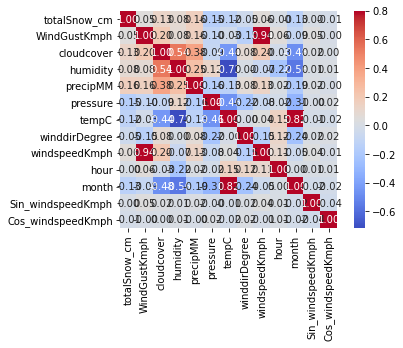

In [5]:
#%% Correlation matrix
import seaborn as sns
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, vmax=.8, square=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90)
plt.show()

In [6]:
#%% CUT-OFF AND ERROR VALUES
Target = pd.merge(Target, rng, on="DateTime", how="outer")
Target = Target.sort_values(by='DateTime', ascending=True)

df = df.set_index('DateTime')
Target = Target.set_index('DateTime')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 

{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.95}
best score
-137.22818765975435


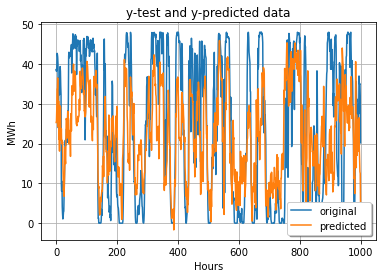

TRAIN: [   0    1    2 ... 1997 1998 1999] VALIDATION: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027
 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041
 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055
 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069
 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083
 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097
 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111
 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125
 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139
 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153
 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167
 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181
 2182 2183 2184 2185 2

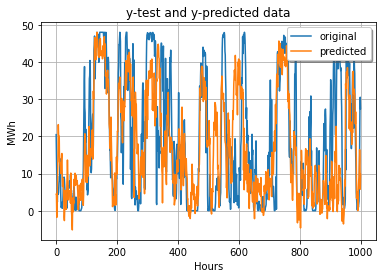

TRAIN: [   0    1    2 ... 2997 2998 2999] VALIDATION: [3000 3001 3002 3003 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013
 3014 3015 3016 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027
 3028 3029 3030 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041
 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055
 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069
 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083
 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097
 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111
 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125
 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139
 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153
 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167
 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181
 3182 3183 3184 3185 3

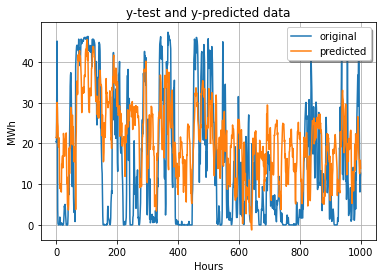

TRAIN: [   0    1    2 ... 3997 3998 3999] VALIDATION: [4000 4001 4002 4003 4004 4005 4006 4007 4008 4009 4010 4011 4012 4013
 4014 4015 4016 4017 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027
 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041
 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055
 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069
 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083
 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097
 4098 4099 4100 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111
 4112 4113 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125
 4126 4127 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139
 4140 4141 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153
 4154 4155 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167
 4168 4169 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181
 4182 4183 4184 4185 4

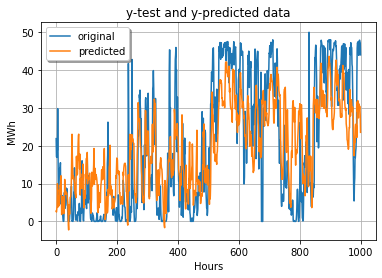

TRAIN: [   0    1    2 ... 4997 4998 4999] VALIDATION: [5000 5001 5002 5003 5004 5005 5006 5007 5008 5009 5010 5011 5012 5013
 5014 5015 5016 5017 5018 5019 5020 5021 5022 5023 5024 5025 5026 5027
 5028 5029 5030 5031 5032 5033 5034 5035 5036 5037 5038 5039 5040 5041
 5042 5043 5044 5045 5046 5047 5048 5049 5050 5051 5052 5053 5054 5055
 5056 5057 5058 5059 5060 5061 5062 5063 5064 5065 5066 5067 5068 5069
 5070 5071 5072 5073 5074 5075 5076 5077 5078 5079 5080 5081 5082 5083
 5084 5085 5086 5087 5088 5089 5090 5091 5092 5093 5094 5095 5096 5097
 5098 5099 5100 5101 5102 5103 5104 5105 5106 5107 5108 5109 5110 5111
 5112 5113 5114 5115 5116 5117 5118 5119 5120 5121 5122 5123 5124 5125
 5126 5127 5128 5129 5130 5131 5132 5133 5134 5135 5136 5137 5138 5139
 5140 5141 5142 5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153
 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167
 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181
 5182 5183 5184 5185 5

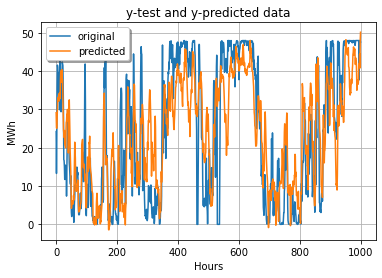

In [7]:
#%% TRAINING AND VALIDATION SET NESTED - CROSS VALIDATION

df = df.values
Target = Target.values

k = 0
n_splits=5

tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
Xgbpred = pd.DataFrame(columns=np.arange(0,n_splits,1)).fillna(0)
maevalues = np.zeros(n_splits)
X_train_append = []
y_train_append = []
X_val_append = []
y_val_append = []
print(tscv)
for train_index, val_index in tscv.split(df):
    print("TRAIN:", train_index, "VALIDATION:", val_index)    
    X_train, X_val = df[train_index], df[val_index]
    y_train, y_val = Target[train_index], Target[val_index]
    X_train_append.append(X_train), y_train_append.append(y_train), X_val_append.append(X_val), y_val_append.append(y_val)
    Xgbpred[k] = XGBoostRegression(X_train,y_train,X_val)
    maevalues[k] = mean_absolute_error(y_val, Xgbpred[k])
    plottingresults(y_val,Xgbpred[k],"y-test and y-predicted data")
    k = k + 1
maevalues = list(maevalues)

In [8]:
#%% TEST SET

start_date = today
end_date = tomorrow
hist_weather_data2 = retrieve_hist_data(api_key, location_list, start_date, end_date, 1, location_label = False, 
                                        export_csv = False, store_df = True)

X_test = hist_weather_data2[0]
X_test = X_test[24:]
X_test['hour'] = pd.DatetimeIndex(X_test['date_time']).hour
X_test['month'] = pd.DatetimeIndex(X_test['date_time']).month
X_test = X_test.set_index('date_time')

for feature in eliminationfeature:
    X_test = X_test.drop(feature, axis = 1)

X_test = X_test.astype(float)

X_test['Sin_windspeedKmph'] = np.sin(X_test['windspeedKmph'])
X_test['Cos_windspeedKmph'] = np.cos(X_test['windspeedKmph'])

X_test = X_test.values



Retrieving weather data for 40.218531,26.832031


Currently retrieving data for 40.218531,26.832031: from 2022-01-29 to 2022-01-30
Time elapsed (hh:mm:ss.ms) 0:00:00.538806


<ipython-input-8-639708f451cb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['hour'] = pd.DatetimeIndex(X_test['date_time']).hour
<ipython-input-8-639708f451cb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['month'] = pd.DatetimeIndex(X_test['date_time']).month


Fitting 5 folds for each of 72 candidates, totalling 360 fits


No handles with labels found to put in legend.


{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}
best score
-133.2962996423053


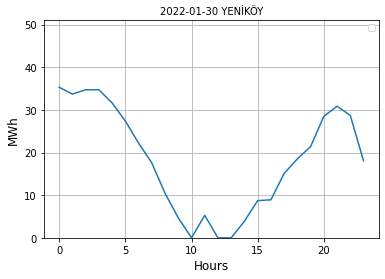

In [9]:
#%% Predictions
result = XGBoostRegression(X_train_append[maevalues.index(min(list(maevalues)))],
                           y_train_append[maevalues.index(min(list(maevalues)))],X_test)

installedcapacity=51
for ij in range(len(result)):
    if result[ij] > installedcapacity:
        result[ij]=installedcapacity
    elif result[ij] < 0:
        result[ij]=0
        
x = range(len(result))
ax = plt.figure().add_subplot(111)
ax.plot(x, list(result), linewidth=1.5)
ax.set_ylim(0, 51)
ax.set_title("{} YENİKÖY".format(end_date), fontsize=10)
ax.set_xlabel('Hours', fontsize=12)
ax.set_ylabel('MWh', fontsize=12)
ax.legend(loc="best", prop={'size': 8})
ax.grid(True)